# STONKS Final Project Submission Code

### Members:
##### Monica Guntur (mg4363 | Section 3)
##### Clemente Domeyko (cd3255 | Section 3)
##### Hsu-Sheng Ko (hk3176 | Section 3)
##### Kazuhiro Matsumoto (km3711 | Section 1)
##### Tarusha Silva (trs2158 | Section 1)


Notes:


*   All pickle dumps have been commented out. 
*   Data scraping has been limited for demo purposes.



## **0) Packages**

In [302]:
# # Uncomment to install/upgrade packages if there are any errors regarding packages.
# !pip install --upgrade pandas
# !pip install yfinance 
# !pip install snscrape
# !pip install vaderSentiment
# !pip uninstall scikit-learn -y
# !pip install -U scikit-learn
# nltk.download('punkt')

In [303]:
import os
import re
import time
import glob
import nltk
import pickle 
import requests
import numpy as np
import pandas as pd
import datetime as dt
from bs4 import BeautifulSoup
from datetime import timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import snscrape.modules.twitter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize,word_tokenize 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

## **1) Data Scraping**

### Opensea Data

#### *Assets*

In [304]:
dict_ = {'id': [], 'token_id': [], 'trait_type': [], 'trait_value': [], 'trait_count': []}
contract_id = '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb'
i = 0
while True:
    # Demo:
    if i == 5:
    # Original:
    # if i == 10000:
        break
        
    url = f"https://api.opensea.io/api/v1/assets?token_ids={i}&order_direction=desc&offset=0&limit=50&asset_contract_address={contract_id}"
    headers = {"X-API-KEY": "REDACTED"} 
    try:
        response = requests.get(url, headers=headers)
        for asset in response.json()['assets']:
                for trait in asset['traits']:
                    dict_['id'].append(asset['id'])
                    dict_['token_id'].append(asset['token_id'])
                    dict_['trait_type'].append(trait['trait_type'])
                    dict_['trait_value'].append(trait['value'])
                    dict_['trait_count'].append(trait['trait_count'])
        i+=1
    except Exception:
        if response.status_code != 200:
            wait = 5
            time.sleep(wait)
            print(f'Status Code is {response.status_code}. i={i} Retrying in {wait} seconds')
            continue

In [305]:
df1 = pd.DataFrame.from_dict(dict_)
df1.head()
# f=open('cryptopunks.bin', 'wb')
# pickle.dump(df1, f)

,id,token_id,trait_type,trait_value,trait_count
0,176533,0,type,Female,3840
1,176533,0,accessory,Green Eye Shadow,271
2,176533,0,accessory,Earring,2459
3,176533,0,accessory,Blonde Bob,147
4,176533,0,accessory,3 attributes,715


In [306]:
f=open('cryptopunks.bin', 'rb')
df1 = pickle.load(f)
df_tmp = pd.DataFrame(df1.groupby(['trait_type', 'trait_value']).mean().groupby('trait_type').sum()['trait_count'])
df_tmp.rename(columns = {'trait_count': 'total_trait_count'}, inplace = True)
df1 = df1.merge(df_tmp, left_on = 'trait_type', right_on = 'trait_type', how='inner')

In [307]:
# Calculate rarity scores.

attr_count = pd.DataFrame(df1.groupby('token_id').size().to_frame('trait_value'))
attr_count.reset_index(inplace=True)
attr_count['trait_value'] = attr_count['trait_value'] - 1
attr_count[attr_count['token_id'] == '2']
attr_count['trait_type'] = 'num_attributes'
temp = pd.DataFrame(attr_count.groupby('trait_value').size().to_frame('trait_count'))
temp['total_trait_count'] = temp['trait_count'].sum()
temp.reset_index(inplace=True)
temp['trait_value'] = pd.to_numeric(temp['trait_value'])
attr_count = attr_count.merge(temp, left_on='trait_value', right_on='trait_value', how='inner')
df_ = attr_count.merge(df1[['id', 'token_id']], left_on='token_id', right_on='token_id', how='outer').drop_duplicates()
df1 = df1.append(df_).reset_index(drop=True)
df1['rarity'] = df1['trait_count'] / df1['total_trait_count']
df1['score'] = 1 / df1['rarity']

In [308]:
df1.head()
# f=open('cryptopunks_num_attr.bin', 'wb')
# pickle.dump(df1, f)

,id,token_id,trait_type,trait_value,trait_count,total_trait_count,rarity,score
0,176533,0,type,Female,3840,10000.0,0.3840,2.604167
1,158831,1,type,Male,6039,10000.0,0.6039,1.655903
2,176802,2,type,Female,3840,10000.0,0.3840,2.604167
3,177630,3,type,Male,6039,10000.0,0.6039,1.655903
4,177489,4,type,Male,6039,10000.0,0.6039,1.655903


In [309]:
score = pd.DataFrame(df1.groupby('token_id').sum()['score'])
rank = score.sort_values(by='score', ascending=False).reset_index()

In [310]:
rank.head()
# f=open('cp_scores.bin', 'wb')
# pickle.dump(rank, f)

,token_id,score
0,8348,10920.289723
1,2202,1816.189511
2,4121,1509.326189
3,7920,1474.436712
4,5622,1471.720111


#### *Events*

In [311]:
dict_ = {'id': [], 'token_id': [], 'event_timestamp': [], 'event_type': [], 'bid_amount': [],
         'starting_price': [], 'ending_price': [], 'total_price': [],  
          'auction_type': [], 'auction_duration': [], 'trans_hash': []
         }
contract_id = '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb'

# Demo: 
for token_id in range(6):
# Original
# for token_id in range(token_count+1):
    events_count = 1
    offset = 0
    print('----token_id: ', token_id)
    
    while events_count != 0:
        print('offset: ', offset)
        url = f"https://api.opensea.io/api/v1/events?asset_contract_address={contract_id}&token_id={token_id}&only_opensea=false&offset={offset}&limit=50"
        headers = {
        "X-API-KEY": "REDACTED"
        }
        
        try:
            response = requests.get(url, headers=headers)
            events = response.json()['asset_events']
        except KeyError:
            wait = 5
            time.sleep(wait)
            print(f'Status Code is {response.status_code}. i={token_id} Retrying in {wait} seconds')
            continue
        
        offset += 50
        events_count = len(events)
        print('events_count: ', events_count)
        
        if events_count == 0:
            pass
        else:
            for event in events:
                try:
                    dict_['id'].append(event['asset']['id'])
                    dict_['token_id'].append(event['asset']['token_id'])
                    dict_['event_type'].append(event['event_type'])
                    dict_['bid_amount'].append(event['bid_amount'])
                    dict_['starting_price'].append(event['starting_price'])
                    dict_['ending_price'].append(event['ending_price'])
                    dict_['total_price'].append(event['total_price'])
                    dict_['auction_type'].append(event['auction_type'])
                    dict_['auction_duration'].append(event['duration'])
                    dict_['event_timestamp'].append(event['transaction']['timestamp'])
                    dict_['trans_hash'].append(event['transaction']['transaction_hash']) 
                except TypeError as e:
                    print(e)
                    dict_['event_timestamp'].append(np.NaN)
                    dict_['trans_hash'].append(np.NaN) 
                    
        if token_id % 100 == 0:
            df2 = pd.DataFrame(dict_)
            print('+++++++++Saved to DF.')

# (don't be alarmed, token_id 1 has a lot of data.)

----token_id:  0
offset:  0
events_count:  39
+++++++++Saved to DF.
offset:  50
events_count:  0
+++++++++Saved to DF.
----token_id:  1
offset:  0
events_count:  50
offset:  50
events_count:  50
offset:  100
events_count:  50
offset:  150
events_count:  50
offset:  200
events_count:  50
offset:  250
events_count:  50
offset:  300
events_count:  50
offset:  350
events_count:  50
offset:  400
events_count:  50
offset:  450
events_count:  50
offset:  500
events_count:  50
offset:  550
events_count:  50
offset:  600
events_count:  50
offset:  650
events_count:  50
offset:  700
events_count:  50
offset:  750
events_count:  50
offset:  800
events_count:  50
offset:  850
events_count:  50
offset:  900
events_count:  50
offset:  950
events_count:  50
offset:  1000
events_count:  50
offset:  1050
events_count:  50
offset:  1100
events_count:  50
offset:  1150
events_count:  50
offset:  1200
events_count:  50
offset:  1250
events_count:  50
offset:  1300
events_count:  50
offset:  1350
events_co

In [312]:
df2.head()
# f=open('cp_events_all.bin', 'wb')
# pickle.dump(df2, f)

,id,token_id,event_timestamp,event_type,bid_amount,starting_price,ending_price,total_price,auction_type,auction_duration,trans_hash
0,176533,0,2021-09-04T04:40:52,bid_withdrawn,321000000000000000000,None,None,None,None,None,0xac9f29bd7760fb80db91174e667aec1bf7ec3304a6fe...
1,176533,0,2021-09-01T09:08:35,bid_entered,321000000000000000000,None,None,None,None,None,0x128d761ab37181f93c691b4bdce5ce587ebc588d1484...
2,176533,0,2021-09-01T06:05:16,bid_withdrawn,320000000000000000000,None,None,None,None,None,0x1d684dcb3589201eec949cb607925e724cbaef25aa8f...
3,176533,0,2021-09-01T04:43:20,bid_entered,320000000000000000000,None,None,None,None,None,0x45d8563b8011d24aaced3e0212a3838ffa224a513689...
4,176533,0,2021-09-01T04:30:55,bid_withdrawn,263000000000000000000,None,None,None,None,None,0x1daa38f2b3829e8b7fe8bca8f828ae8c4aac2c199267...


### Ethereum Prices



In [313]:
df = yf.download("ETH-USD") 
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'])
df[['Date', 'Close']].head()

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2015-08-07,2.772120
1,2015-08-08,0.753325
2,2015-08-09,0.701897
3,2015-08-10,0.708448
4,2015-08-11,1.067860


In [314]:
f=open('cp_events_all.bin', 'rb')
df2 = pickle.load(f)

In [315]:
df2['event_timestamp'] = pd.to_datetime(df2['event_timestamp'])
df2['date'] = pd.to_datetime(df2['event_timestamp'].dt.date)
df2 = df2.merge(df[['Date', 'Close']], left_on='date', right_on='Date', how='inner')
df2.drop(columns=['date', 'Date'], inplace=True)

In [316]:
df2.head()
# f=open('cp_events_USD.bin', 'wb')
# pickle.dump(df2, f)

,id,token_id,event_timestamp,event_type,bid_amount,starting_price,ending_price,total_price,auction_type,auction_duration,trans_hash,Close
0,176533,0,2021-09-04 04:40:52,bid_withdrawn,321000000000000000000,None,None,None,None,None,0xac9f29bd7760fb80db91174e667aec1bf7ec3304a6fe...,3887.828369
1,158831,1,2021-09-04 04:40:52,bid_withdrawn,198000000000000000000,None,None,None,None,None,0x5c512a2945d5a35e15df73a4251b0057f65339f0262e...,3887.828369
2,178142,6,2021-09-04 03:32:48,bid_entered,1000000000000000000,None,None,None,None,None,0x724771948629760cb5c42aad8163ed11f0099504e272...,3887.828369
3,178145,28,2021-09-04 03:43:28,bid_entered,500000000000000000,None,None,None,None,None,0x025620b6a8ddc939e404a7bfe45184ac46455b14347c...,3887.828369
4,524871,35,2021-09-04 03:48:27,bid_entered,500000000000000000,None,None,None,None,None,0xbd826b8afe8328de2a000bdd760b69721bb8214b15e5...,3887.828369


### Market Conditions

In [317]:
f = open('cp_events_USD.bin', 'rb')
df = pickle.load(f)
df['Date'] = pd.to_datetime(df['event_timestamp'].dt.date)

In [318]:
cwd = os.getcwd()
path = cwd+'/*.csv'
for fname in glob.glob(path):
    if fname == cwd+'/cp_avg.csv': pass
    else:
        df1 = pd.read_csv(fname)
        df1['Date'] = pd.to_datetime(df1['Date'])
        name = df1.columns[1]
        df1[name+'_daily'] = df1[name].diff(periods=1)
        df1.at[0, name+'_daily'] = 0
        df = df.merge(df1, left_on='Date', right_on='Date', how='inner')

In [319]:
avg = pd.read_csv(cwd+'/cp_avg.csv')
avg['Date'] = pd.to_datetime(avg['Date'])
df = df.merge(avg, left_on='Date', right_on='Date', how='inner')

In [320]:
df.head()
# f=open('cp_events_market.bin', 'wb')
# pickle.dump(df, f)

,id,token_id,event_timestamp,event_type,bid_amount,starting_price,ending_price,total_price,auction_type,auction_duration,...,Primary Sales USD_daily,Primary Sales,Primary Sales_daily,Sales USD,Sales USD_daily,Average USD_x,Average USD_daily,Active Market Wallets,Active Market Wallets_daily,Average USD_y
0,176533,0,2021-09-04 04:40:52,bid_withdrawn,321000000000000000000,None,None,None,None,None,...,0.0,2141,0.0,1.216925e+09,16654012.13,66426.02,841.04,4907,9.0,66426.02
1,158831,1,2021-09-04 04:40:52,bid_withdrawn,198000000000000000000,None,None,None,None,None,...,0.0,2141,0.0,1.216925e+09,16654012.13,66426.02,841.04,4907,9.0,66426.02
2,178142,6,2021-09-04 03:32:48,bid_entered,1000000000000000000,None,None,None,None,None,...,0.0,2141,0.0,1.216925e+09,16654012.13,66426.02,841.04,4907,9.0,66426.02
3,178145,28,2021-09-04 03:43:28,bid_entered,500000000000000000,None,None,None,None,None,...,0.0,2141,0.0,1.216925e+09,16654012.13,66426.02,841.04,4907,9.0,66426.02
4,524871,35,2021-09-04 03:48:27,bid_entered,500000000000000000,None,None,None,None,None,...,0.0,2141,0.0,1.216925e+09,16654012.13,66426.02,841.04,4907,9.0,66426.02


### Missing Data Fix

In [321]:
f = open('cp_scores.bin', 'rb')
scores = pickle.load(f)
f1=open('cp_events_market.bin', 'rb')
df = pickle.load(f1)

In [322]:
missing = df[(df.total_price=='0') & (df.event_type=='successful')]
missing_tk = list(missing.token_id.unique())
missing_data = {'token_id':[], 'price':[], 'date':[]}

# Demo:
for token_id in missing_tk[:6]:
# Original:
# for token_id in missing_tk:
    url = f"https://larvalabs.com/cryptopunks/details/{token_id}"
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    sold_data = results_page.find_all('tr', {'class':'punk-history-row-sold'})
    for s in sold_data:
        missing_data['token_id'].append(token_id)
        missing_data['price'].append(s.find_all('td')[3].get_text())
        missing_data['date'].append(s.find_all('td')[4].get_text())

m_df = pd.DataFrame(missing_data)
m_df.head()

,token_id,price,date
0,1859,"80Ξ ($371,304)","Nov 14, 2021"
1,1859,"109.90Ξ ($398,469)","Sep 16, 2021"
2,1859,0.00Ξ ($0.00),"Sep 01, 2021"
3,1859,"82Ξ ($263,701)","Aug 25, 2021"
4,1859,"6.79Ξ ($2,477)","Sep 28, 2020"


In [323]:
temp = m_df.copy()
temp.price = temp.price.apply(lambda x: re.findall('\((.*?)\)',x)[0].strip('<()$').replace(',',''))
temp.price= temp.price.replace({'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
temp.price= temp.price.astype(float)
temp.date = pd.to_datetime(temp.date)
temp = temp.rename(columns={'price': 'sold_usd', 'date':'Date'})

In [324]:
sold = df[df.event_type == 'successful'].copy()
sold['sold_usd'] = (sold['total_price'].astype(float) / 10**18) * sold['Close']
sold = sold.drop(columns=['bid_amount',
       'starting_price', 'ending_price', 'total_price', 'auction_type',
       'auction_duration', 'trans_hash', 'Close', 'event_type', 'event_timestamp', 'id'])

In [325]:
missing = sold[sold.sold_usd==0]
sold = sold[sold.sold_usd!=0]
missing = missing.merge(temp, left_on=['token_id', 'Date'],right_on=['token_id', 'Date'])
missing = missing.drop(columns=['sold_usd_x'])
missing = missing.rename(columns={'sold_usd_y':'sold_usd'})
sold = sold.append(missing)
sold = sold[sold.sold_usd!=0]

In [326]:
sold.head()
# f=open('cp_sold_fix.bin', 'wb')
# pickle.dump(sold, f)

,token_id,Date,Secondary Sales USD,Secondary Sales USD_daily,Unique Buyers,Unique Buyers_daily,Primary Sales USD,Primary Sales USD_daily,Unique Sellers,Unique Sellers_daily,...,Secondary Sales,Secondary Sales_daily,Active Market Wallets,Active Market Wallets_daily,Sales USD,Sales USD_daily,Primary Sales,Primary Sales_daily,Average USD,sold_usd
6,618,2021-09-04,1.106619e+09,16654012.13,4348,4.0,1.103052e+08,0.0,2701,7.0,...,16179,19.0,4907,9.0,1.216925e+09,16654012.13,2141,0.0,66426.02,378091.308899
13,1186,2021-09-04,1.106619e+09,16654012.13,4348,4.0,1.103052e+08,0.0,2701,7.0,...,16179,19.0,4907,9.0,1.216925e+09,16654012.13,2141,0.0,66426.02,381007.180176
19,1316,2021-09-04,1.106619e+09,16654012.13,4348,4.0,1.103052e+08,0.0,2701,7.0,...,16179,19.0,4907,9.0,1.216925e+09,16654012.13,2141,0.0,66426.02,408221.978760
31,1633,2021-09-04,1.106619e+09,16654012.13,4348,4.0,1.103052e+08,0.0,2701,7.0,...,16179,19.0,4907,9.0,1.216925e+09,16654012.13,2141,0.0,66426.02,388782.836914
32,1711,2021-09-04,1.106619e+09,16654012.13,4348,4.0,1.103052e+08,0.0,2701,7.0,...,16179,19.0,4907,9.0,1.216925e+09,16654012.13,2141,0.0,66426.02,408183.100476


### Token Ask-Bid By Month

In [327]:
f = open('cp_events_usd.bin', 'rb')
df2 = pickle.load(f)

df_bid_entered = df2[df2['event_type'] == 'bid_entered'] # bid_entered is amount bidded by buyer
df_created = df2[df2['event_type'] == 'created'] # created is amount asked by seller.

df_bid_entered['bid_amount_usd_price'] = (df_bid_entered['bid_amount'].astype(float) / 10**18) * df_bid_entered['Close']
df_created['ending_price_usd'] = (df_created['ending_price'].astype(float) / 10**18) * df_created['Close']

cp_bid_entered = df_bid_entered[['token_id', 'event_timestamp', 'bid_amount_usd_price']]
cp_created = df_created[['token_id', 'event_timestamp', 'ending_price_usd']]

# Create Max Bid

cp_bid_entered['event_timestamp'] = pd.to_datetime(cp_bid_entered['event_timestamp'])
cp_bid_entered['date'] = pd.to_datetime(cp_bid_entered['event_timestamp'].dt.date)
cp_bid_entered.set_index(['date'], inplace=True)

cp_bid_entered['year'] = [int(str(x)) for x in cp_bid_entered.index.year]
cp_bid_entered['month'] = [int(str(x)) for x in cp_bid_entered.index.month]

grouped = pd.DataFrame(cp_bid_entered.groupby(['token_id', 'year', 'month'])['bid_amount_usd_price'].max())
grouped = grouped.reset_index()
date = list()
for i in range(len(grouped)):
    date.append(str(grouped['year'][i]) + '-' + str(grouped['month'][i]))
grouped['date'] = date
grouped = grouped[['date', 'token_id', 'bid_amount_usd_price']]
bid = grouped.rename(columns={'bid_amount_usd_price': 'max_bid_usd_price'})

# Create Min Ask

cp_created['event_timestamp'] = pd.to_datetime(cp_created['event_timestamp'])
cp_created['date'] = pd.to_datetime(cp_created['event_timestamp'].dt.date)
cp_created.set_index(['date'], inplace=True)

cp_created['year'] = [int(str(x)) for x in cp_created.index.year]
cp_created['month'] = [int(str(x)) for x in cp_created.index.month]
cp_created = cp_created.dropna()

grouped = pd.DataFrame(cp_created.groupby(['token_id', 'year', 'month'])['ending_price_usd'].min())
grouped = grouped.reset_index()
date = list()
for i in range(len(grouped)):
    date.append(str(grouped['year'][i]) + '-' + str(grouped['month'][i]))
grouped['date'] = date
grouped = grouped[['date', 'token_id', 'ending_price_usd']]
ask = grouped.rename(columns={'ending_price_usd': 'min_ask_usd_price'})

# Join both datasets in one:

complete = pd.merge(bid, ask,  how='outer', left_on=['date','token_id'], right_on = ['date','token_id'])
complete = complete[['token_id', 'date', 'max_bid_usd_price', 'min_ask_usd_price']]
complete = complete.sort_values(['token_id', 'date'], ascending=[True, True])
complete = complete.reset_index(drop=True)

In [328]:
# f=open('token_ask_bid_by_month.bin', 'wb')
# pickle.dump(complete, f)
complete

,token_id,date,max_bid_usd_price,min_ask_usd_price
0,0,2017-6,334.904233,NaN
1,0,2017-7,3197.882965,NaN
2,0,2018-11,2829.285431,NaN
3,0,2019-12,5835.873291,NaN
4,0,2019-4,6558.469849,NaN
...,...,...,...,...
31184,9999,2021-2,99.279626,NaN
31185,9999,2021-3,180.697180,NaN
31186,9999,2021-4,40778.691406,NaN
31187,9999,2021-5,840.458396,NaN


### Twitter Sentiment

In [329]:
filename='cp_events_all.bin'
pickle_in=open(filename,"rb")
cp_events=pickle.load(pickle_in)

In [330]:
#getting only sales transactions
cp_sales=cp_events[cp_events['event_type']=='successful'].reset_index(drop=True)
#dropping columns I don't need
cp_sales.drop(['id','bid_amount','starting_price','ending_price','auction_type','auction_duration','trans_hash'],axis=1, inplace=True)
#converting sales price to float and divding by ETH wei
cp_sales['total_price']=cp_sales['total_price'].astype(float)
cp_sales['total_price']=(cp_sales['total_price']//(10**18))
#dropping rows will null values for dates
cp_sales = cp_sales[cp_sales['event_timestamp'].notna()]

In [331]:
#formatting the dates to fit twitter API/snscrape and getting historical dates to pair with the current date to put in the twitter search query
def get_tweet_date(x):
    new_date=x[:10]
    return str(new_date)

In [332]:
cp_sales['event_timestamp']=cp_sales['event_timestamp'].astype(str)
cp_sales['event_timestamp']=cp_sales['event_timestamp'].apply(get_tweet_date)

In [333]:
cp_sales['event_timestamp'] = cp_sales['event_timestamp'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d'))
#getting the date one day before the transaction occured
cp_sales['one_day_back']= (cp_sales['event_timestamp']- timedelta(days=1))

In [334]:
#reformatting date columns to fit our scraping model
cp_sales['event_timestamp']=cp_sales['event_timestamp'].astype(str)
cp_sales['event_timestamp']=cp_sales['event_timestamp'].apply(get_tweet_date)

#reformatting date columns to fit our scraping model
cp_sales['one_day_back']=cp_sales['one_day_back'].astype(str)
cp_sales['one_day_back']=cp_sales['one_day_back'].apply(get_tweet_date)

In [335]:
#dropping the unusual transaction on 28 Oct 2021 for token #9998
cp_sales=cp_sales.drop(index=17680).reset_index(drop=True) 

In [336]:
#a function to get a list of lists with transaction date, day prior to transaction and sales price:
tweet_scraper_list=[]
for i in range(len(cp_sales.index)):
    entering_list=[cp_sales['event_timestamp'].iloc[i],cp_sales['one_day_back'].iloc[i],cp_sales['total_price'].iloc[i]]
    tweet_scraper_list.append(entering_list)
tweet_scraper_list   

[['2018-11-30', '2018-11-29', 0.0],
 ['2017-07-07', '2017-07-06', 0.0],
 ['2017-06-23', '2017-06-22', 0.0],
 ['2020-11-30', '2020-11-29', 60.0],
 ['2019-04-06', '2019-04-05', 31.0],
 ['2017-06-26', '2017-06-25', 0.0],
 ['2018-12-07', '2018-12-06', 2.0],
 ['2017-07-17', '2017-07-16', 1.0],
 ['2017-07-13', '2017-07-12', 0.0],
 ['2017-07-10', '2017-07-09', 0.0],
 ['2021-08-23', '2021-08-22', 129.0],
 ['2021-02-19', '2021-02-18', 22.0],
 ['2021-02-01', '2021-01-31', 20.0],
 ['2020-09-06', '2020-09-05', 19.0],
 ['2020-05-28', '2020-05-27', 20.0],
 ['2017-07-12', '2017-07-11', 0.0],
 ['2017-07-17', '2017-07-16', 2.0],
 ['2017-07-11', '2017-07-10', 1.0],
 ['2021-05-04', '2021-05-03', 20.0],
 ['2021-03-11', '2021-03-10', 20.0],
 ['2021-06-10', '2021-06-09', 17.0],
 ['2021-03-08', '2021-03-07', 19.0],
 ['2021-03-07', '2021-03-06', 15.0],
 ['2021-08-23', '2021-08-22', 57.0],
 ['2021-08-15', '2021-08-14', 42.0],
 ['2021-04-06', '2021-04-05', 15.0],
 ['2021-04-06', '2021-04-05', 14.0],
 ['2021-04-

The primary code will take a lot of time to run as the scraping method is time intensive (we were not able to use tweepy as Twitter API only allows to get historical tweets up to the most recent 7 days in the past, which does not fit our purspose as we have transactions going back to 2017). Hence, the demo below is for a subset of the tweet_scraper_list above that will show an output in limited time.


In [337]:
#demo list of lists with transaction date, day prior to transaction and sales price:
mini_tweet_scraper_list=tweet_scraper_list[:5] 

In [338]:
#extracting tweets using snscrape
all_tweets=[]
for j in range(len(mini_tweet_scraper_list)):
    start=mini_tweet_scraper_list[j][1]
    finish=mini_tweet_scraper_list[j][0]
    search="CryptoPunks since:"+start+" until:"+finish
    x=snscrape.modules.twitter.TwitterSearchScraper(query=search)
    tweets_list=[]
    try:
        for i,tweet in enumerate(x.get_items()):
            if i>100: #analyzing only 100 tweets from the day
                continue
            tweets_list.append(str(tweet.content))
        entering_text=''
        for tweet in tweets_list:
            entering_text+=tweet+"."
        entering_list=[j,entering_text]
        all_tweets.append(entering_list)
    except Exception:
        wait = 5
        time.sleep(wait)
        continue

In [339]:
#feeding the tweets to vaderSentiment
headers = ['pos','neg','neu','compound']
texts = all_tweets
analyzer = SentimentIntensityAnalyzer()
interested=[]
for k in range(len(texts)):
    name = texts[k][0]
    sentences = sent_tokenize(texts[k][1])
    pos=compound=neu=neg=0
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        pos+=vs['pos']/(len(sentences))
        compound+=vs['compound']/(len(sentences))
        neu+=vs['neu']/(len(sentences))
        neg+=vs['neg']/(len(sentences))
    entering_list=[tweet_scraper_list[k][0],tweet_scraper_list[k][2],compound]
    interested.append(entering_list)

In [340]:
#extracting x and y values as lists
sentiment=[]
price=[]
for e in range(len(interested)):
    price.append(interested[e][1])
    sentiment.append(interested[e][2])

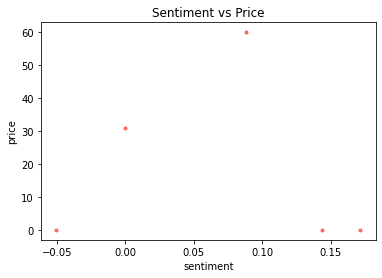

In [341]:
# Create plot data
x = sentiment
y = price
area = np.pi*3

# Plot
plt.scatter(x, y, s=area, c='r', alpha=0.5)
plt.title('Sentiment vs Price')
plt.xlabel('sentiment')
plt.ylabel('price')
plt.show()

## **2) Data Exploration**

### Attribute Prices

In [342]:
f = open('cryptopunks_num_attr.bin', 'rb')
df = pickle.load(f)
f = open('cp_events_USD.bin', 'rb')
df2 = pickle.load(f)
f = open('cp_scores.bin', 'rb')
scores = pickle.load(f)
f = open('token_ask_bid_by_month.bin', 'rb')
df3 = pickle.load(f)

<AxesSubplot:>

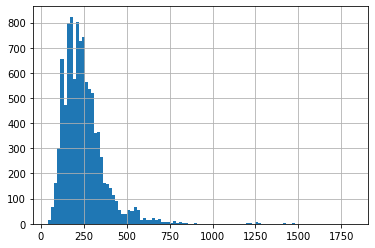

In [343]:
scores[scores['token_id'] != '8348']['score'].hist(bins=100)

In [344]:
max_bid = pd.DataFrame(df3.groupby('token_id')['max_bid_usd_price'].max())

<AxesSubplot:xlabel='score', ylabel='max'>

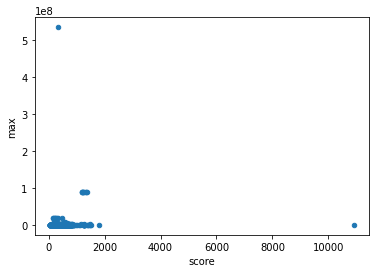

In [345]:
df2['sold_usd'] = (df2['total_price'].astype(float) / 10**18) * df2['Close']
tk_max = df2.groupby('token_id')[['sold_usd']].max()
max_value = tk_max.merge(max_bid, left_on='token_id', right_on='token_id')
max_value['max'] = max_value[['sold_usd', 'max_bid_usd_price']].max(axis=1)
price_score = pd.DataFrame(max_value[['max']].merge(scores, left_on='token_id', right_on='token_id')).set_index('token_id')
 
price_score.plot.scatter(x='score', y='max')

In [346]:
# drop max_bid > 1e7. these transactions were created by owners who artificially inflated the price.
# https://twitter.com/larvalabs/status/1453903818308083720
df3.drop(df3[df3.max_bid_usd_price > 1e7].index, inplace=True)
max_bid = pd.DataFrame(df3.groupby('token_id')['max_bid_usd_price'].max())

In [347]:
df2['sold_usd'] = (df2['total_price'].astype(float) / 10**18) * df2['Close']
tk_max = df2.groupby('token_id')[['sold_usd']].max()

In [348]:
max_value = tk_max.merge(max_bid, left_on='token_id', right_on='token_id')
max_value['max'] = max_value[['sold_usd', 'max_bid_usd_price']].max(axis=1)

<AxesSubplot:xlabel='score', ylabel='max'>

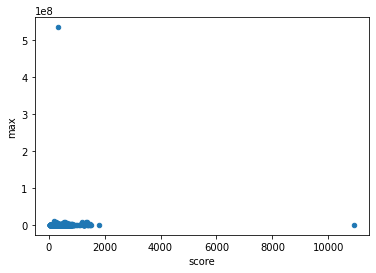

In [349]:
price_score = pd.DataFrame(max_value[['max']].merge(scores, left_on='token_id', right_on='token_id')).set_index('token_id')
price_score.plot.scatter(x='score', y='max')

<AxesSubplot:xlabel='score', ylabel='max'>

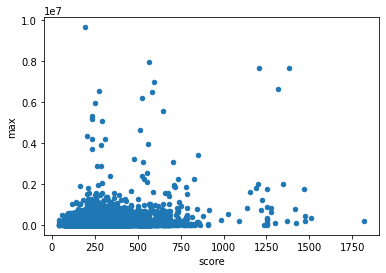

In [350]:
# same issue as the artifical bid price
price_score.at['9998', 'max'] = 346575
price_score[price_score.index != '8348'].plot.scatter(x='score', y='max')

In [351]:
price_score.head()
# f=open('price_score.bin', 'wb')
# pickle.dump(price_score, f)

,max,score
token_id,,
0,1.230980e+06,304.985225
1,7.506160e+05,182.621688
10,4.634942e+04,171.389943
100,2.519744e+03,187.347680
1000,1.289750e+06,424.038584


In [352]:
attr_value = df.merge(price_score[['max']], left_on='token_id', right_on='token_id')
avg_attr = attr_value.groupby('trait_value').mean()
avg_attr.drop(avg_attr[avg_attr.index == 7].index, inplace=True) # drop outlier

<AxesSubplot:xlabel='trait_value'>

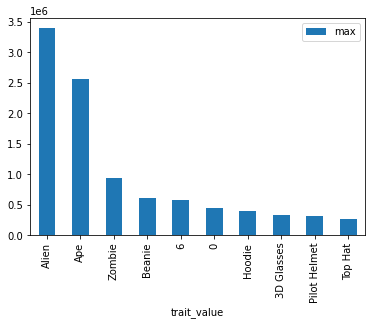

In [353]:
top_10 = avg_attr.sort_values(by='max', ascending=False).head(10)
top_10.plot.bar(y='max')

<AxesSubplot:xlabel='trait_value'>

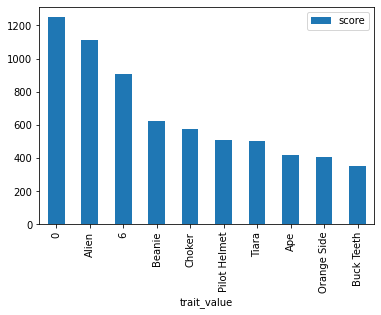

In [354]:
top_10_s = avg_attr.sort_values(by='score', ascending=False).head(10)
top_10_s.plot.bar(y='score')

<AxesSubplot:xlabel='score', ylabel='max'>

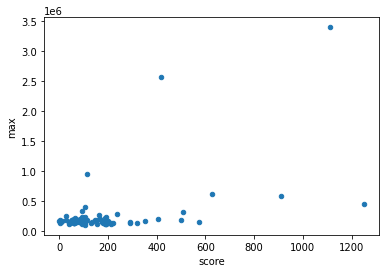

In [355]:
avg_attr.plot.scatter(x='score', y='max')

In [356]:
main = df.merge(avg_attr[['max']], left_on='trait_value', right_on='trait_value')
main_ = main.groupby('token_id').sum()[['score', 'max']]
main_.rename(columns={'max':'sum_avg'}, inplace=True)
final = price_score[['max']].merge(main_, left_on='token_id', right_on='token_id')
final = final.dropna()
final = final.drop(['8348'])

<AxesSubplot:xlabel='score', ylabel='sum_avg'>

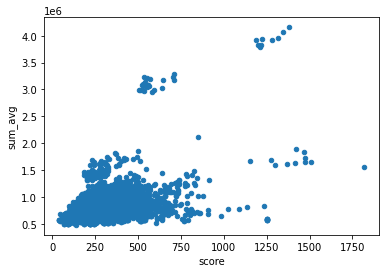

In [357]:
final.plot.scatter(x='score', y='sum_avg')

## **3) Data Transformation & Models**

### K-Means

In [358]:
f = open('cryptopunks_num_attr.bin', 'rb')
df = pickle.load(f)
f = open('cp_events_USD.bin', 'rb')
df2 = pickle.load(f)

In [359]:
traits = df[['token_id','trait_value']]
traits.set_index(['token_id'], inplace=True)
encode = pd.get_dummies(traits.trait_value, drop_first=True).groupby('token_id').aggregate(sum)
encode.head()

,1,2,3,4,5,6,7,3D Glasses,Alien,Ape,...,Tiara,Top Hat,VR,Vampire Hair,Vape,Welding Goggles,Wild Blonde,Wild Hair,Wild White Hair,Zombie
token_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [360]:
K = 20
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
for k in range(5,K):
    Kmean = KMeans(n_clusters=k)
    model = Kmean.fit(encode)
    Kmean.inertia_/(len(encode)) 

    distortions.append(sum(np.min(cdist(encode, model.cluster_centers_,
                                        'euclidean'), axis=1)) / encode.shape[0])
    inertias.append(model.inertia_)
 
    mapping1[k] = sum(np.min(cdist(encode, model.cluster_centers_,
                                   'euclidean'), axis=1)) / encode.shape[0]
    mapping2[k] = model.inertia_

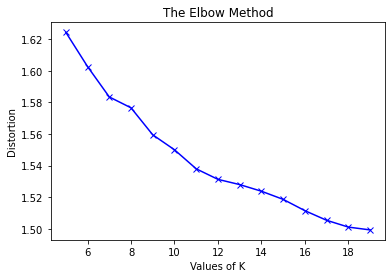

In [361]:
plt.plot(mapping1.keys(), distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [362]:
K = 11
Kmean = KMeans(n_clusters=K)
model = Kmean.fit(encode)  
print(model.labels_)
print(Kmean.inertia_/(len(encode)))
print(set(model.labels_))

[3 2 7 ... 2 6 0]
2.4388084036520348
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


In [363]:
cp_labels = list(zip(encode.index, model.labels_))
cp_clusters = pd.DataFrame(cp_labels).rename(columns={0: 'token_id',1: 'cluster'})
cp_clusters.head()

,token_id,cluster
0,0,3
1,1,2
2,10,7
3,100,8
4,1000,3


In [364]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(encode)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['labels'] = pd.Series(model.labels_)

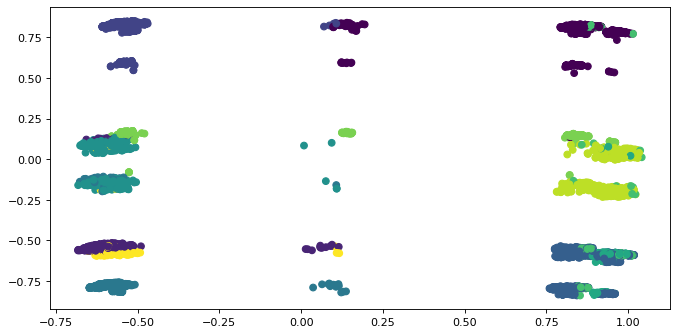

In [365]:
fig = plt.figure(figsize=(10, 5), dpi=80)
labels = list(set(model.labels_))
plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1], c=principalDf.iloc[:,2] )
plt.show()

#### *First Approach Results*

In [366]:
f = open('price_score.bin', 'rb')
scores = pickle.load(f)

In [367]:
tk_by_cluster = cp_clusters.groupby('cluster')['token_id'].apply(list).reset_index(name='tokens')
c_scores = []
c_max = []
for c in set(Kmean.labels_):
    tokens = map(str, list(tk_by_cluster[tk_by_cluster['cluster'] == c]['tokens'])[0])
    t_df = scores[scores.index.isin(tokens)]
    c_scores.append(t_df['score'].sum() / len(t_df))
    c_max.append(t_df['max'].sum() / len(t_df))

tk_by_cluster['avg_score'] = c_scores
tk_by_cluster['avg_price'] = c_max

<AxesSubplot:>

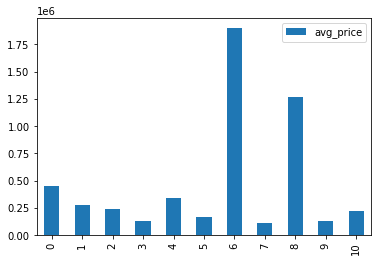

In [368]:
tk_by_cluster.plot.bar(y='avg_price')

<AxesSubplot:>

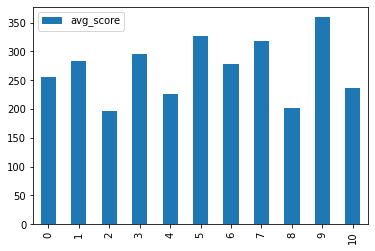

In [369]:
tk_by_cluster.plot.bar(y='avg_score')

In [370]:
def plot_cluster_traits(cluster):
    tokens = list(tk_by_cluster[tk_by_cluster['cluster'] == cluster]['tokens'])[0]
    c = df[(df.token_id.isin(tokens)) & (df.trait_type != 'num_attributes')]
    c.groupby('trait_value').size().sort_values(ascending = False)[:7].plot(kind = 'barh')

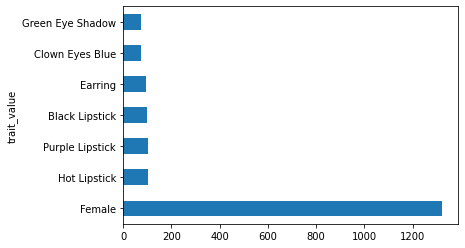

In [371]:
plot_cluster_traits(0)

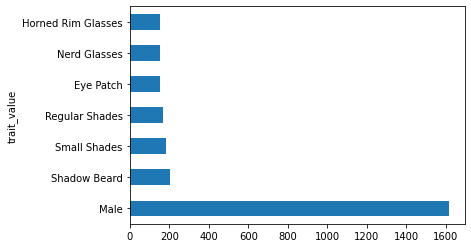

In [372]:
plot_cluster_traits(1)

#### *Second Approach: PCA+Scaling*

In [373]:
f = open('cryptopunks_num_attr.bin', 'rb')
df = pickle.load(f)

In [374]:
df['token_id'] = df['token_id'].astype(int)

In [375]:
pv = pd.pivot_table(df[df['trait_type'] != 'num_attributes'], index=['token_id'], columns='trait_value')['score']
pv

trait_value,3D Glasses,Alien,Ape,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,...,Tiara,Top Hat,VR,Vampire Hair,Vape,Welding Goggles,Wild Blonde,Wild Hair,Wild White Hair,Zombie
token_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.340136,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.608501,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.608501,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,51.474766,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.608501,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,113.636364


In [376]:
pv.fillna(0, inplace = True)
pv

trait_value,3D Glasses,Alien,Ape,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,...,Tiara,Top Hat,VR,Vampire Hair,Vape,Welding Goggles,Wild Blonde,Wild Hair,Wild White Hair,Zombie
token_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,187.340136,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.608501,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.608501,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,51.474766,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.608501,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,113.636364


In [377]:
pv_norm = pv.apply(lambda x: (x - x.mean()) / x.std(), axis = 0)
pv_norm

trait_value,3D Glasses,Alien,Ape,Bandana,Beanie,Big Beard,Big Shades,Black Lipstick,Blonde Bob,Blonde Short,...,Tiara,Top Hat,VR,Vampire Hair,Vape,Welding Goggles,Wild Blonde,Wild Hair,Wild White Hair,Zombie
token_id,,,,,,,,,,,,,,,,,,,,,
0,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,8.186605,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,-0.216303,-0.117414,-0.094219
1,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,-0.216303,-0.117414,-0.094219
2,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,4.622686,-0.117414,-0.094219
3,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,4.622686,-0.117414,-0.094219
4,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,4.205927,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,4.622686,-0.117414,-0.094219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,-0.216303,-0.117414,-0.094219
9996,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,-0.216303,-0.117414,-0.094219
9997,-0.171578,-0.030012,-0.049046,-0.224779,-0.066476,-0.121716,-0.237736,-0.256419,-0.122139,-0.114312,...,-0.074363,-0.107855,-0.185302,-0.122139,-0.167206,-0.093133,-0.120867,-0.216303,-0.117414,10.612497


In [378]:
pca = PCA()
pca.fit(pv_norm)
pc_score = pd.DataFrame(pca.transform(pv_norm))
pc_score

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,2.868173,0.015396,0.077127,0.535661,-0.335486,-0.322381,0.452947,-0.589473,0.104624,-0.681804,...,0.554771,0.696739,-0.513933,1.184192,1.352752,0.075647,0.141721,-0.114036,-0.024812,8.930306e-15
1,-1.365979,0.277975,0.636110,0.359752,1.001173,0.704619,-0.480693,0.012484,-1.335782,1.398615,...,-1.242636,2.645720,-0.353439,-0.066309,0.125630,0.299847,-0.337179,-0.645911,-0.032008,-2.784281e-15
2,1.197628,-0.102925,-0.634811,0.392736,1.543410,-0.065400,-0.379572,-0.437902,0.629324,-0.753663,...,-0.413878,0.375271,-0.670773,-0.128514,0.175829,-0.387245,-1.792246,0.156235,-0.029622,5.132997e-15
3,-0.968424,0.216092,-2.133291,-0.859155,0.301874,-1.588515,-0.773756,-0.414124,1.316726,-0.115280,...,-0.232928,-1.034752,0.961075,-0.017721,0.465628,-0.667771,0.657437,-0.418772,-0.045071,-4.121753e-15
4,-1.473681,-0.152193,-1.082115,-1.106225,2.376299,-0.787320,0.089004,-1.688375,-0.995726,0.418189,...,-0.796541,1.175936,-1.033122,-0.379432,0.374982,0.353263,0.510411,0.435645,-0.018720,-3.930933e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.888454,-0.499063,0.438271,0.558832,0.333121,-1.549595,-0.698022,-0.607535,0.217817,-0.129798,...,-0.391399,0.383538,-0.313895,2.051179,1.710082,0.029644,-0.019249,-0.134050,-0.018998,6.159953e-15
9996,-1.231159,0.775177,3.186400,-0.152631,0.642421,2.028754,-0.640694,-0.437191,-1.571255,0.764401,...,-1.720991,2.481818,1.575252,-0.421053,0.162359,0.404156,0.117389,-0.295777,-0.029352,-3.469497e-15
9997,-0.811582,0.634547,2.753210,2.411835,0.329264,0.997934,1.562852,-0.369210,2.805948,0.072168,...,0.964858,-0.661837,0.021536,0.683851,-0.610650,0.510838,-0.083453,0.475104,-0.032364,-1.095023e-14
9998,3.196252,2.508700,0.045246,-0.264444,0.473563,-0.620402,-0.669843,0.370975,-0.094736,0.091503,...,-0.503147,-0.273174,-1.107412,-0.145846,-0.140138,0.578319,0.831396,-0.313926,-0.029874,2.229070e-15


In [379]:
cont = pd.DataFrame(pca.explained_variance_ratio_)
cont

,0
0,3.849033e-02
1,1.283045e-02
2,1.276729e-02
3,1.264458e-02
4,1.262715e-02
...,...
87,5.289069e-03
88,3.368839e-03
89,2.912432e-03
90,2.751762e-04


In [380]:
cont['cum_cont'] = cont[0].cumsum()
cont[cont['cum_cont'] <= 0.7]

,0,cum_cont
0,0.038490,0.038490
1,0.012830,0.051321
2,0.012767,0.064088
3,0.012645,0.076733
4,0.012627,0.089360
5,0.012571,0.101931
6,0.012400,0.114331
7,0.012346,0.126676
8,0.012255,0.138932
9,0.012242,0.151174


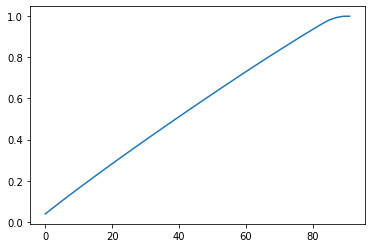

In [381]:
plt.plot(cont['cum_cont'])

In [382]:
N =57
data = pc_score.iloc[:, :N + 1]
data

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,2.868173,0.015396,0.077127,0.535661,-0.335486,-0.322381,0.452947,-0.589473,0.104624,-0.681804,...,2.899858,-0.578039,-2.031937,1.354410,0.785918,0.603703,-0.594045,-0.109180,-1.233258,-1.473272
1,-1.365979,0.277975,0.636110,0.359752,1.001173,0.704619,-0.480693,0.012484,-1.335782,1.398615,...,-0.988199,-0.521195,-0.412874,1.826768,-0.737168,-0.381474,-1.209211,0.207553,0.080051,1.147594
2,1.197628,-0.102925,-0.634811,0.392736,1.543410,-0.065400,-0.379572,-0.437902,0.629324,-0.753663,...,-0.202534,-1.251428,0.132058,-0.042734,-0.662389,1.165479,0.472258,-0.139904,-0.237779,-0.856512
3,-0.968424,0.216092,-2.133291,-0.859155,0.301874,-1.588515,-0.773756,-0.414124,1.316726,-0.115280,...,-0.778601,-1.031151,0.643378,1.302252,-0.753038,0.688153,1.299789,0.233404,-0.333397,-1.273013
4,-1.473681,-0.152193,-1.082115,-1.106225,2.376299,-0.787320,0.089004,-1.688375,-0.995726,0.418189,...,-0.734195,-0.291221,-2.032265,-0.187705,-0.621032,0.748710,-0.132621,-0.147182,-1.287729,-0.828332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.888454,-0.499063,0.438271,0.558832,0.333121,-1.549595,-0.698022,-0.607535,0.217817,-0.129798,...,-2.064319,1.565396,0.622694,-1.224245,0.906477,1.515130,-2.950907,-1.320978,-1.991744,-1.168722
9996,-1.231159,0.775177,3.186400,-0.152631,0.642421,2.028754,-0.640694,-0.437191,-1.571255,0.764401,...,-0.837723,-0.711483,-0.143840,1.751245,0.171377,-0.116079,-0.822162,-0.417633,1.158478,-0.483935
9997,-0.811582,0.634547,2.753210,2.411835,0.329264,0.997934,1.562852,-0.369210,2.805948,0.072168,...,1.036121,0.231601,-1.091196,-1.276646,1.348222,0.922501,-0.613311,5.592152,-2.190245,2.132227
9998,3.196252,2.508700,0.045246,-0.264444,0.473563,-0.620402,-0.669843,0.370975,-0.094736,0.091503,...,1.829830,1.036096,0.042889,1.152963,-0.507468,0.292940,-0.981970,0.356097,-1.538286,0.385723


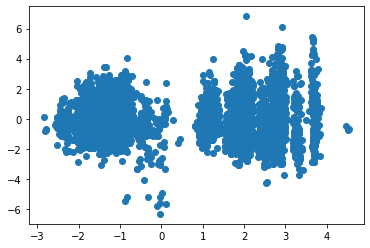

In [383]:
plt.scatter(x = pc_score.iloc[:, 0], y = pc_score.iloc[:, 1])

#### *Second Approach Results*

In [384]:
K = 11
Kmean = KMeans(n_clusters = K)
Kmean.fit(data)
centers = Kmean.cluster_centers_
labels = Kmean.labels_
print(centers)
print(labels)
print(Kmean.inertia_ / (len(data)))

[[-7.00051927e-01 -6.13627069e-01  8.84413036e-01 -8.72172692e-01
  -2.86886700e-01 -4.73000587e-01  7.93784946e-02  5.10493430e-01
   3.93868105e-01  6.75029616e-01 -1.37164717e-01  7.26116385e-01
   1.68028099e+00  3.03130135e-01  7.53987225e-01  1.05535406e-01
  -4.59755569e-01  6.24274264e-01  4.86455778e-01  8.54785528e-01
   1.79228814e-01 -5.92699182e-01 -7.04867323e-02  1.05204524e+00
   2.52917093e-01  3.30657269e-01 -6.69662866e-01  4.35929648e-01
  -3.56423471e-02  2.90226365e-01  3.33856856e-01  6.23085214e-01
  -3.27453005e-01 -1.72317841e-01 -9.57968518e-01 -5.05342606e-01
   1.05673431e+00  3.19135602e-01  7.59206705e-01  1.85129319e-01
   2.32391018e-01  7.90347851e-01  5.78668117e-01 -7.16754134e-01
   3.01044421e-01  3.76174920e-01 -8.40341370e-01 -7.23563127e-01
   3.79401393e-01 -3.76041702e-01  5.43444594e-02  4.74654934e-01
   9.74338979e-02  3.30224496e-01 -9.00171245e-01  6.92221385e-01
   8.43401433e-02  8.83978371e-01]
 [-3.44158914e-01  2.14281017e-01  2.5776

In [385]:
cp_labels = list(zip(data.index, Kmean.labels_))
cp_clusters = pd.DataFrame(cp_labels).rename(columns={0: 'token_id',1: 'cluster'})
tk_by_cluster = cp_clusters.groupby('cluster')['token_id'].apply(list).reset_index(name='tokens')
f = open('price_score.bin', 'rb')
scores = pickle.load(f)

In [386]:
c_scores = []
c_max = []
for c in set(Kmean.labels_):
    tokens = map(str, list(tk_by_cluster[tk_by_cluster['cluster'] == c]['tokens'])[0])
    t_df = scores[scores.index.isin(tokens)]
    c_scores.append(t_df['score'].sum() / len(t_df))
    c_max.append(t_df['max'].sum() / len(t_df))

tk_by_cluster['avg_score'] = c_scores
tk_by_cluster['avg_price'] = c_max

<AxesSubplot:>

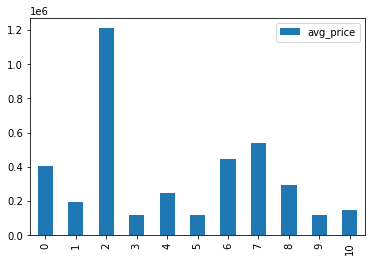

In [387]:
tk_by_cluster.plot.bar(y='avg_price')

<AxesSubplot:>

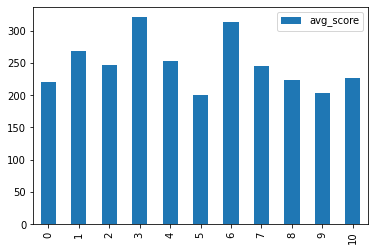

In [388]:
tk_by_cluster.plot.bar(y='avg_score')

In [389]:
def plot_cluster_traits(cluster):
    tokens = list(tk_by_cluster[tk_by_cluster['cluster'] == cluster]['tokens'])[0]
    c = df[(df.token_id.isin(tokens)) & (df.trait_type != 'num_attributes')]
    c.groupby('trait_value').size().sort_values(ascending = False)[:7].plot(kind = 'barh')

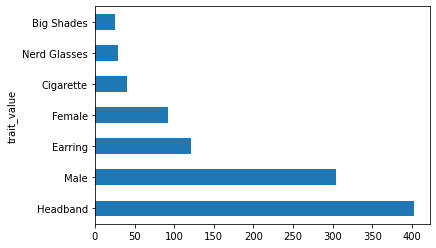

In [390]:
plot_cluster_traits(0)

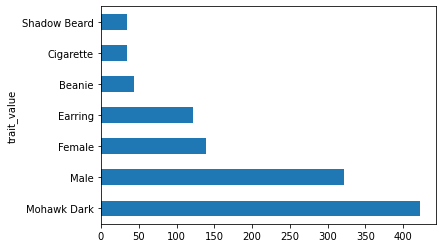

In [391]:
plot_cluster_traits(1)

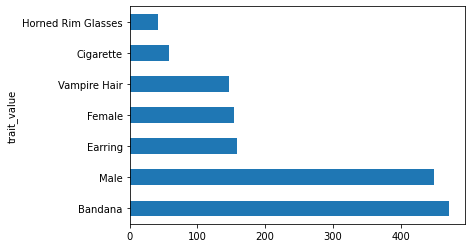

In [392]:
plot_cluster_traits(2)

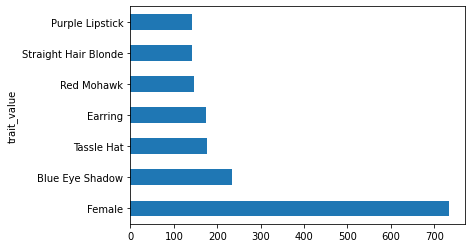

In [393]:
plot_cluster_traits(3)

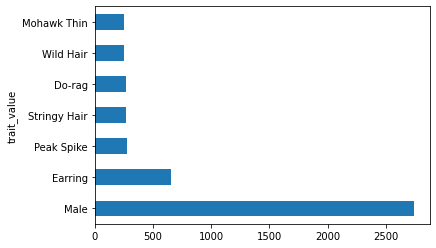

In [394]:
plot_cluster_traits(4)

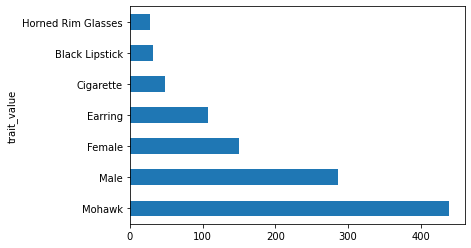

In [395]:
plot_cluster_traits(5)

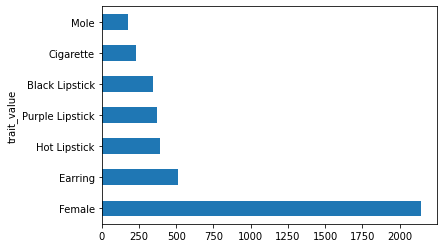

In [396]:
plot_cluster_traits(6)

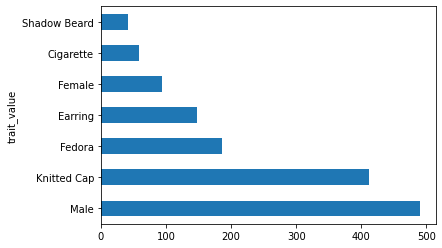

In [397]:
plot_cluster_traits(7)

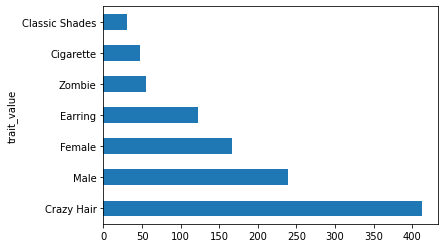

In [398]:
plot_cluster_traits(8)

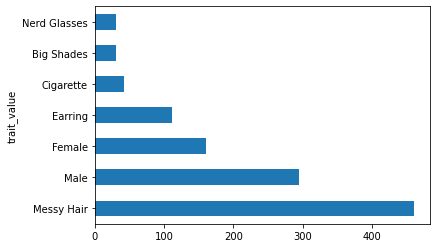

In [399]:
plot_cluster_traits(9)

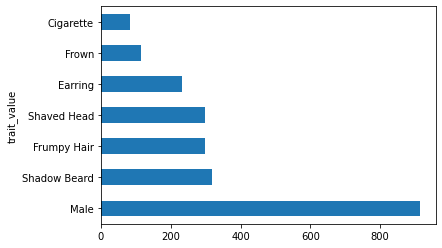

In [400]:
plot_cluster_traits(10)

### Classification
#### *Data Transformation*

In [401]:
f = open('cryptopunks_num_attr.bin', 'rb')
df = pickle.load(f)
f = open('cp_events_usd.bin', 'rb')
df2 = pickle.load(f)
# each row in df contains one property of one token
# properties are : type or accessory
# type can be : alien, male, female, ape, zombie
# attributes can be Headband, Eyepatch etc...
# one row contains how many attributes each token has

# print example of token 3100 : type alien, attributes headband, num_attributes 1
df[df['token_id'] == '0']

# create a dataframe of tokens

idx = df.token_id.unique()

tokens = pd.DataFrame(index = idx)
tokens['type'] = ""
tokens['num_attrs'] = ""
tokens['attribute0'] = ""
tokens['attribute1'] = ""
tokens['attribute2'] = ""
tokens['attribute3'] = ""
tokens['attribute4'] = ""
tokens['attribute5'] = ""
tokens['attribute6'] = ""

token_attrs = {}
token_type = {}

for i in idx:
    token_attrs[i] = []
    token_type[int(i)] = ''
    
for index,row in df.iterrows():
    if row.trait_type == 'accessory':
        token_attrs[row.token_id].append(row.trait_value)
    if row.trait_type == 'type':
        tokens.iloc[int(row.token_id),0] = row.trait_value
    if row.trait_type == 'num_attributes':
        tokens.iloc[int(row.token_id),1] = row.trait_value

token_attrs_sorted = list(map(lambda x : sorted(token_attrs[x]), token_attrs))

for i,attrs in enumerate(token_attrs_sorted):
    for j,attr in enumerate(attrs):
        tokens.iloc[i,2 + j] = attr


# token contains the following columns
# type
# num attributes
# attribute0 to attribute7, in alphabetical order
tokens = tokens.astype({
    'num_attrs': 'int32',
})

# Create OHLC data
sales = df2[df2.event_type == 'successful'][['token_id','event_timestamp','total_price','Close']]

annual_values = pd.DataFrame(index = idx)

annual_values['close2017'] = 0
annual_values['close2018'] = 0
annual_values['close2019'] = 0
annual_values['close2020'] = 0
annual_values['close2021'] = 0

for i in annual_values.index:
    # calculate close for each year
    last_2017 = []
    is_2017 = True
    try:
        last_2017 = sales[
            (sales.token_id == i) & 
            (sales.event_timestamp >= pd.Timestamp('2017-01-01')) &
            (sales.event_timestamp <  pd.Timestamp('2018-01-01'))].sort_values('event_timestamp').iloc[-1]
    except Exception:
        is_2017 = False
    
    last_2018 = []
    is_2018 = True
    try:
        last_2018 = sales[
            (sales.token_id == i) & 
            (sales.event_timestamp >= pd.Timestamp('2018-01-01')) &
            (sales.event_timestamp <  pd.Timestamp('2019-01-01'))].sort_values('event_timestamp').iloc[-1]
    except Exception:
        is_2018 = False
        pass
    
    last_2019 = []
    is_2019 = True
    try:
        last_2019 = sales[
            (sales.token_id == i) & 
            (sales.event_timestamp >= pd.Timestamp('2019-01-01')) &
            (sales.event_timestamp <  pd.Timestamp('2020-01-01'))].sort_values('event_timestamp').iloc[-1]
    except Exception:
        is_2019 = False
        pass
    
    last_2020 = []
    is_2020 = True
    try:
        last_2020 = sales[
            (sales.token_id == i) & 
            (sales.event_timestamp >= pd.Timestamp('2020-01-01')) &
            (sales.event_timestamp <  pd.Timestamp('2021-01-01'))].sort_values('event_timestamp').iloc[-1]
    except Exception:
        is_2020 = False
        pass
    
    last_2021 = []
    is_2021 = True
    try:
        last_2021 = sales[
            (sales.token_id == i) & 
            (sales.event_timestamp >= pd.Timestamp('2021-01-01')) &
            (sales.event_timestamp <  pd.Timestamp('2022-01-01'))].sort_values('event_timestamp').iloc[-1]
    except Exception:
        is_2021 = False
        pass
            
    annual_values.loc[i]['close2017'] = (float(last_2017.total_price)/(10**18)) * last_2017.Close if (is_2017) else 0
    annual_values.loc[i]['close2018'] = (float(last_2018.total_price)/(10**18)) * last_2018.Close if (is_2018) else 0
    annual_values.loc[i]['close2019'] = (float(last_2019.total_price)/(10**18)) * last_2019.Close if (is_2019) else 0
    annual_values.loc[i]['close2020'] = (float(last_2020.total_price)/(10**18)) * last_2020.Close if (is_2020) else 0
    annual_values.loc[i]['close2021'] = (float(last_2021.total_price)/(10**18)) * last_2021.Close if (is_2021) else 0


# Extend token with sales data
tokens = tokens.join(annual_values)

In [402]:
# f=open('tokens.bin', 'wb')
# pickle.dump(tokens, f)

### Logistic Regression Classifier

#### *Logistic Regression without Last Price*


The mean cross-validation accuracy is: 0.390 +/- 0.014
model score: 0.41


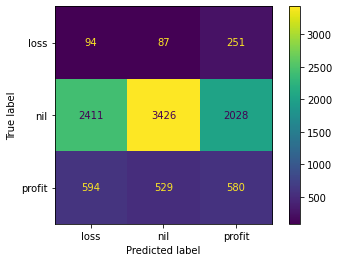

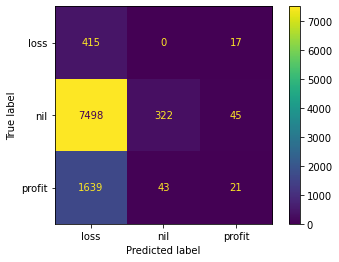

In [403]:
# Load data
f = open('tokens.bin', 'rb')
tokens = pickle.load(f)

# create data
tokens_only = tokens.drop(['close2017','close2018','close2019','close2020','close2021'], axis = 1)
profit_2018 = (tokens['close2018'] - tokens['close2017']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2019 = (tokens['close2019'] - tokens['close2018']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2020 = (tokens['close2020'] - tokens['close2019']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")

tokens_2018 = tokens_only
tokens_2019 = tokens_only
tokens_2020 = tokens_only

# setup columns
num_col_selector = make_column_selector(dtype_exclude=object)
cat_col_selector = make_column_selector(dtype_include=object)

num_cols = num_col_selector(tokens_2020)
cat_cols = cat_col_selector(tokens_2020)

# preprocess columns
cat_preproc = OneHotEncoder(handle_unknown="ignore")
num_preproc = StandardScaler()

# create preprocessing pipeline
preproc = ColumnTransformer([
    ('one-hot-encoder', cat_preproc, cat_cols),
    ('standard_scaler', num_preproc, num_cols)])

# create logistic regression pipeline
model = make_pipeline(preproc, LogisticRegression(max_iter=500, class_weight = 'balanced'))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)


# Changing the threshold
threshold = 0.75
out = []
for i in model.predict_proba(tokens_2020):
    if i[2] > threshold:
        out.append("profit")
    elif i[1] > threshold:
        out.append("nil")
    else:
        out.append("loss")
profit_2020_pred = np.array(out).astype(object)

ConfusionMatrixDisplay.from_predictions(profit_2020, profit_2020_pred)

#### *Logistic Regression with Last Price*

The mean cross-validation accuracy is: 0.826 +/- 0.006
model score: 0.829
roc auc score: 0.7618060821200556
The mean cross-validation accuracy is: 0.621 +/- 0.025
model score: 0.6378
roc auc score: 0.8118527540943866


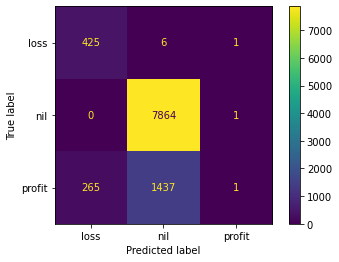

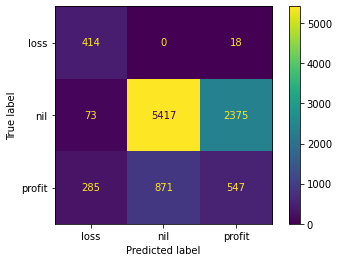

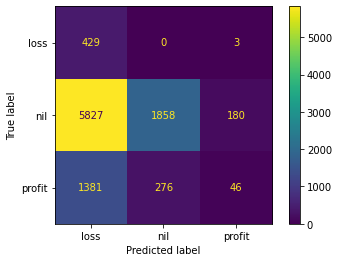

In [404]:
# Load data
f = open('tokens.bin', 'rb')
tokens = pickle.load(f)

# create data
tokens_only = tokens.drop(['close2017','close2018','close2019','close2020','close2021'], axis = 1)
profit_2018 = (tokens['close2018'] - tokens['close2017']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2019 = (tokens['close2019'] - tokens['close2018']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2020 = (tokens['close2020'] - tokens['close2019']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")

tokens_2019 = tokens_only.join(profit_2018)
tokens_2020 = tokens_only.join(profit_2019)

# setup columns
num_col_selector = make_column_selector(dtype_exclude=object)
cat_col_selector = make_column_selector(dtype_include=object)

num_cols = num_col_selector(tokens_2020)
cat_cols = cat_col_selector(tokens_2020)

# preprocess columns
cat_preproc = OneHotEncoder(handle_unknown="ignore")
num_preproc = StandardScaler()

# create preprocessing pipeline
preproc = ColumnTransformer([
    ('one-hot-encoder', cat_preproc, cat_cols),
    ('standard_scaler', num_preproc, num_cols)])

# create logistic regression pipeline
model = make_pipeline(preproc, LogisticRegression(max_iter=500))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

# roc auc
y_true = profit_2020
y_pred = model.predict_proba(tokens_2020)
roc_auc = roc_auc_score(y_true, y_pred, multi_class = 'ovo', average='macro')
print(f"roc auc score: {roc_auc}")

# create logistic regression pipeline
model = make_pipeline(preproc, LogisticRegression(max_iter=500, class_weight = 'balanced'))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

# roc auc
y_true = profit_2020
y_pred = model.predict_proba(tokens_2020)
roc_auc = roc_auc_score(y_true, y_pred, multi_class = 'ovo', average='macro')
print(f"roc auc score: {roc_auc}")

# threshold
threshold = 0.75
out = []
for i in model.predict_proba(tokens_2020):
    if i[2] > threshold:
        out.append("profit")
    elif i[1] > threshold:
        out.append("nil")
    else:
        out.append("loss")
profit_2020_pred = np.array(out).astype(object)

ConfusionMatrixDisplay.from_predictions(profit_2020, profit_2020_pred)

### Gradient Boosted Classifier


#### *Without Last Price*

The mean cross-validation accuracy is: 0.782 +/- 0.002
model score: 0.7856


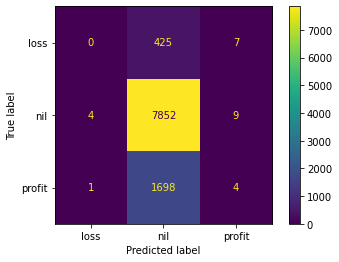

In [405]:
# Load data
f = open('tokens.bin', 'rb')
tokens = pickle.load(f)

# create data
tokens_only = tokens.drop(['close2017','close2018','close2019','close2020','close2021'], axis = 1)
profit_2018 = (tokens['close2018'] - tokens['close2017']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2019 = (tokens['close2019'] - tokens['close2018']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2020 = (tokens['close2020'] - tokens['close2019']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")

tokens_2018 = tokens_only
tokens_2019 = tokens_only
tokens_2020 = tokens_only

# setup columns
num_col_selector = make_column_selector(dtype_exclude=object)
cat_col_selector = make_column_selector(dtype_include=object)

num_cols = num_col_selector(tokens_2020)
cat_cols = cat_col_selector(tokens_2020)

# preprocess columns
cat_preproc = OneHotEncoder(handle_unknown="ignore")
num_preproc = StandardScaler()

# create preprocessing pipeline
preproc = ColumnTransformer([
    ('one-hot-encoder', cat_preproc, cat_cols),
    ('standard_scaler', num_preproc, num_cols)])

# create logistic regression pipeline
model = make_pipeline(preproc,
                      GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

#### *With last price* 

The mean cross-validation accuracy is: 0.810 +/- 0.007
model score: 0.8126
roc auc score: 0.40413166414051654


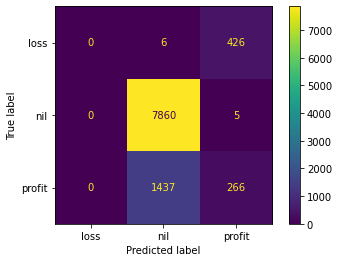

In [406]:
# Load data
f = open('tokens.bin', 'rb')
tokens = pickle.load(f)

# create data
tokens_only = tokens.drop(['close2017','close2018','close2019','close2020','close2021'], axis = 1)
profit_2018 = (tokens['close2018'] - tokens['close2017']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2019 = (tokens['close2019'] - tokens['close2018']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")
profit_2020 = (tokens['close2020'] - tokens['close2019']).apply(lambda x : "profit" if (x>0) else ("loss" if x < 0 else "nil")).rename("lastprofit")

tokens_2019 = tokens_only.join(profit_2018)
tokens_2020 = tokens_only.join(profit_2019)

# setup columns
num_col_selector = make_column_selector(dtype_exclude=object)
cat_col_selector = make_column_selector(dtype_include=object)

num_cols = num_col_selector(tokens_2020)
cat_cols = cat_col_selector(tokens_2020)

# preprocess columns
cat_preproc = OneHotEncoder(handle_unknown="ignore")
num_preproc = StandardScaler()

# create preprocessing pipeline
preproc = ColumnTransformer([
    ('one-hot-encoder', cat_preproc, cat_cols),
    ('standard_scaler', num_preproc, num_cols)])


# create logistic regression pipeline
model = make_pipeline(preproc,
                      GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))

# cross-validation
cv = cross_validate(model, tokens_2020, profit_2020, cv = 5)
scores = cv["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

# fit the model to 2019 data
model.fit(tokens_2019, profit_2019)

# score the model on 2020 data
print(f"model score: {model.score(tokens_2020, profit_2020)}")

# confusion matrix
ConfusionMatrixDisplay.from_estimator(model, tokens_2020, profit_2020)

# roc auc
y_true = profit_2020
y_pred = model.predict_proba(tokens_2020)
roc_auc = roc_auc_score(y_true, y_pred, multi_class = 'ovo', average='macro')
print(f"roc auc score: {roc_auc}")

#### *Visualization*


<AxesSubplot:>

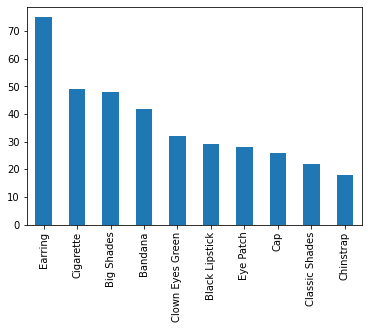

In [407]:
profit_2020_pred = model.predict(tokens_2020)
tokens_2020_pred_profit = tokens_2020[profit_2020_pred == 'profit']
tokens_2020_pred_profit['attribute0'].value_counts()[:10].plot.bar()

<AxesSubplot:>

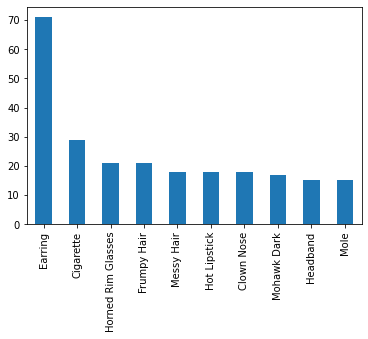

In [408]:
tokens_2020_pred_profit['attribute1'].value_counts()[:10].plot.bar()

<AxesSubplot:>

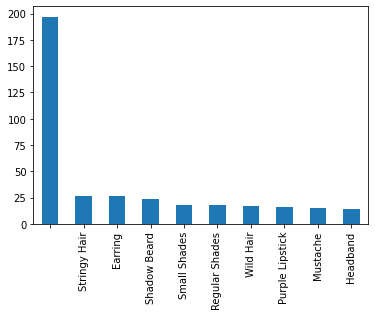

In [409]:
tokens_2020_pred_profit['attribute2'].value_counts()[:10].plot.bar()

### Classification with Market Condition Data

#### Creating token_market_by_month data in a time series fashion

In [410]:
f=open('cp_events_market.bin', 'rb')
df1 = pickle.load(f)

df1['event_timestamp'] = pd.to_datetime(df1['event_timestamp'].dt.date)
df1['year'] = [int(str(x.year)) for x in df1['event_timestamp']]
df1['month'] = [int(str(x.month)) for x in df1['event_timestamp']]
df1['Date'] = df1['year'].astype(str) + '-' + df1['month'].astype(str)
df1['bid_amount_usd_price'] = (df1['bid_amount'].astype(float) / 10**18) * df1['Close']

grouped = df1[['token_id', 'year', 'month', 'bid_amount_usd_price', 'Secondary Sales USD', 'Unique Buyers', 'Primary Sales USD', 'Unique Sellers', 'Average USD', 'Number of Sales', 'Secondary Sales', 'Active Market Wallets', 'Sales USD', 'Primary Sales']]\
             .groupby(['token_id', 'year', 'month'])\
             .agg({'bid_amount_usd_price':'max', 'Secondary Sales USD':'max', 'Unique Buyers':'max', 'Primary Sales USD':'max', 'Unique Sellers':'max', 'Average USD':'max', 'Number of Sales':'max', 'Secondary Sales':'max', 'Active Market Wallets':'max', 'Sales USD':'max', 'Primary Sales':'max'})\
             .rename(columns={'bid_amount_usd_price':'max_bid_amount_usd_price', 'Secondary Sales USD':'max_Secondary_Sales_USD', 'Unique Buyers':'max_Unique_Buyers', 'Primary Sales USD':'max_Primary_Sales_USD', 'Unique Sellers':'max_Unique_Sellers', 'Average USD':'max_Average_USD', 'Number of Sales':'max_Number_of_Sales', 'Secondary Sales':'max_Secondary_Sales', 'Active Market Wallets':'max_Active_Market_Wallets', 'Sales USD':'max_Sales_USD', 'Primary Sales':'max_Primary_Sales'})\
             .reset_index()

grouped['Date'] = grouped['year'].astype(str) + '-' + grouped['month'].astype(str)
grouped = grouped[['token_id', 'Date', 'max_bid_amount_usd_price', 'max_Secondary_Sales_USD', 'max_Unique_Buyers', 'max_Primary_Sales_USD', 'max_Unique_Sellers', 'max_Average_USD', 'max_Number_of_Sales', 'max_Secondary_Sales', 'max_Active_Market_Wallets', 'max_Sales_USD', 'max_Primary_Sales']]

grouped = grouped.dropna()

grouped = grouped.set_index(['token_id', 'Date'])
grouped = grouped.groupby('token_id').pct_change(periods=1).reset_index()

# counting infinity in a particular column name
for i in ['max_bid_amount_usd_price', 'max_Secondary_Sales_USD', 'max_Unique_Buyers', 'max_Primary_Sales_USD', 'max_Unique_Sellers', 'max_Average_USD', 'max_Number_of_Sales', 'max_Secondary_Sales', 'max_Active_Market_Wallets', 'max_Sales_USD', 'max_Primary_Sales']:
    
    c = np.isinf(grouped[i]).values.sum()
    print(i, " contains " + str(c) + " infinite values")

grouped = grouped.drop(['max_Primary_Sales_USD', 'max_Primary_Sales'], axis=1)
grouped = grouped.dropna()

# now each row is by itself, does not matter the order!
grouped['status'] = np.where(grouped['max_bid_amount_usd_price'] >= 0, 1, np.where(grouped['max_bid_amount_usd_price'] < 0, 0, np.nan))

# Saving the data ina file:
# f=open('token_market_by_month.bin', 'wb')
# pickle.dump(grouped, f)

grouped

max_bid_amount_usd_price  contains 0 infinite values
max_Secondary_Sales_USD  contains 0 infinite values
max_Unique_Buyers  contains 0 infinite values
max_Primary_Sales_USD  contains 2502 infinite values
max_Unique_Sellers  contains 0 infinite values
max_Average_USD  contains 0 infinite values
max_Number_of_Sales  contains 0 infinite values
max_Secondary_Sales  contains 0 infinite values
max_Active_Market_Wallets  contains 0 infinite values
max_Sales_USD  contains 0 infinite values
max_Primary_Sales  contains 2502 infinite values


,token_id,Date,max_bid_amount_usd_price,max_Secondary_Sales_USD,max_Unique_Buyers,max_Unique_Sellers,max_Average_USD,max_Number_of_Sales,max_Secondary_Sales,max_Active_Market_Wallets,max_Sales_USD,status
1,0,2017-7,8.548649,18.146958,1.222222,1.666667,1.464618,6.584906,6.584906,1.321429,18.146958,1.0
2,0,2018-11,-0.115263,3.915613,7.425000,1.875000,0.027049,3.786070,3.786070,5.046154,3.915613,0.0
3,0,2019-4,1.318066,0.076179,0.169139,0.252174,-0.076069,0.164761,0.164761,0.162850,0.076179,1.0
4,0,2019-5,-0.306185,0.121964,0.081218,0.062500,0.012660,0.107988,0.107988,0.074398,0.121964,0.0
5,0,2019-12,0.282507,0.210784,0.171362,0.176471,-0.030508,0.248892,0.248892,0.154786,0.210784,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18697,9999,2021-2,169414.927602,3.362128,0.337290,0.323214,2.920095,0.178253,0.157370,0.329236,3.618884,1.0
18698,9999,2021-3,0.820083,5.032752,0.522929,0.524966,3.683857,0.266729,0.245951,0.520476,4.933181,1.0
18699,9999,2021-4,224.674199,0.770210,0.253035,0.285841,0.482688,0.174001,0.165112,0.245873,0.740677,1.0
18700,9999,2021-5,-0.979390,0.219011,0.060078,0.077770,0.163040,0.046013,0.046428,0.062413,0.216555,0.0


### Logistic Regression

In [411]:
f = open('token_market_by_month.bin', 'rb')
grouped = pickle.load(f)

# Data arrenge:

X = grouped.iloc[:,3:-1].values
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Y = grouped.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

print('xtrain shape: ', x_train.shape)
print('ytrain shape: ', y_train.shape)

model = linear_model.LogisticRegression()
model.fit(x_train,y_train)
predictions = model.predict(x_test)
actuals = np.array(y_test)

tp=tn=fp=fn=0
for i in range(len(actuals)):
    a_class=p_class=0
    if int(actuals[i] == 0):
        a_class = 1
    if int(predictions[i] == 0):
        p_class = 1
    if a_class == 1 and p_class == 1:
        tp +=1
    elif a_class == 1 and p_class == 0:
        fn +=1
    elif a_class == 0 and p_class == 0:
        tn +=1
    elif a_class == 0 and p_class == 1:
        fp +=1
print('True Positive: ', tp)
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print("Accuracy: %f"%((tp+tn)*100/(tp+tn+fp+fn)))

xtrain shape:  (9281, 8)
ytrain shape:  (9281,)
True Positive:  0
True Negative:  1959
False Positive:  0
False Negative:  362
Accuracy: 84.403274


### Random Forest

In [412]:
# Data arrenge:

X = grouped.iloc[:,3:-1].values
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Y = grouped.iloc[:,-1].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

print('xtrain shape: ', x_train.shape)
print('ytrain shape: ', y_train.shape)


# Random Forest

parameters = {
     'n_estimators':(10,30, 50,100), #the number of trees
     'max_samples':(.30,.40,.50,1.0),
     'max_features':(5,10,20,60),
     
}

model = GridSearchCV(BaggingClassifier(),parameters,cv=3)
inputs = X
outputs = Y
model.fit(inputs, np.ravel(outputs))
model.best_score_, model.best_params_

rf = BaggingClassifier(max_features=model.best_params_['max_features'],max_samples=model.best_params_['max_samples'],n_estimators=model.best_params_['n_estimators'])

rf.fit(x_train,y_train)
predicted = rf.predict(x_test)

actuals = y_test

tp=tn=fp=fn=0
for i in range(len(actuals)):
    a_class=p_class=0
    if int(actuals[i] == 0):
        a_class = 1
    if int(predicted[i] == 0):
        p_class = 1
    if a_class == 1 and p_class == 1:
        tp +=1
    elif a_class == 1 and p_class == 0:
        fn +=1
    elif a_class == 0 and p_class == 0:
        tn +=1
    elif a_class == 0 and p_class == 1:
        fp +=1
print('True Positive: ', tp)
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print("Accuracy: %f"%((tp+tn)*100/(tp+tn+fp+fn)))


xtrain shape:  (9281, 8)
ytrain shape:  (9281,)
True Positive:  127
True Negative:  1886
False Positive:  73
False Negative:  235
Accuracy: 86.729858


### Neural Network

In [413]:
# Data arrenge:

X = grouped.iloc[:,3:-1].values
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Y = grouped.iloc[:,-1].values

def one_hot_encoder(array):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    encoder.fit(array)
    coded_array = encoder.transform(array)
    n = len(coded_array)
    n_labels = len(np.unique(coded_array))
    one_hot = np.zeros((n,n_labels))
    one_hot[np.arange(n), coded_array] = 1
    return one_hot

Y = one_hot_encoder(Y)

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.20, random_state = 0)

print('xtrain shape: ', xtrain.shape)
print('ytrain shape: ', ytrain.shape)

# MLPClassifier

epochs = 500

clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(60,), max_iter = epochs, random_state=1) # alpha is the learning rate

clf.fit(xtrain, ytrain)

predictions = clf.predict(xtest)
actuals = ytest

tp=tn=fp=fn=0
for i in range(len(actuals)):
    a_class=p_class=0
    if int(actuals[i][0] == 0):
        a_class = 1
    if int(predictions[i][0] == 0):
        p_class = 1
    if a_class == 1 and p_class == 1:
        tp +=1
    elif a_class == 1 and p_class == 0:
        fn +=1
    elif a_class == 0 and p_class == 0:
        tn +=1
    elif a_class == 0 and p_class == 1:
        fp +=1
print('True Positive: ', tp)
print('True Negative: ', tn)
print('False Positive: ', fp)
print('False Negative: ', fn)
print("Accuracy: %f"%((tp+tn)*100/(tp+tn+fp+fn)))

xtrain shape:  (9281, 8)
ytrain shape:  (9281, 2)
True Positive:  1959
True Negative:  0
False Positive:  362
False Negative:  0
Accuracy: 84.403274
